<a href="https://colab.research.google.com/github/gbam-ds/Lista/blob/main/Lista_GBaroni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

A resolução da lista de Machine Learning está nesse notebook. Ele se divide em mais duas seções, sendo uma para cada exercício. Há ainda sub-seções para melhor orientar o processo lógico, então, por favor, acompanhe o índice.

Vale ressaltar que esse notebook e a base de dados primáris são encontrados no meu [github](https://github.com/gbam-ds/Lista).

#Exercício 01

## Introdução e Resultados

O objetivo desse exercício é melhorar o MAPE (Mean Absolute Percentage Error) depois da utilização dos modelos vistos até agora.

Em aula, atingimos uma porcentagem da taxa média de erros absolutos em torno de 8-9%, como será apresentado em seguida.

Para melhorar a acurácia, (1) fiz uma análise exploratória da base de dados, (2) retirei variáveis que não me agregariam e criei
outras, (3) tratei outliers, (4) modelei usando diversos métodos e (5) finalizei criando um blending com os modelos para obter uma
melhor previsão.

O resultado foi o seguinte: consegui reduzir o MAPE para 0.005, fazendo o blending.

## Código de aula

In [2]:
# Core
import pandas as pd
import numpy as np
from scipy.stats import skew
from scipy.stats import norm
from scipy import stats
%matplotlib inline
from mlxtend.regressor import StackingCVRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression


# Visual
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7.5]
import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')



#Scikit
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split


from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV


Trabalhando com a base

In [5]:
url = 'https://raw.githubusercontent.com/gbam-ds/Lista/main/train.csv'
df = pd.read_csv(url, index_col=0)
train, test = train_test_split(df, test_size=0.3, random_state=7)
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], #excluindo ID  
                      test.loc[:,'MSSubClass':'SaleCondition'])) #e SalePrice

#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
all_data = pd.get_dummies(all_data)

#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y_train = train.SalePrice
y_test = test.SalePrice

####Definindo MAPE

In [6]:
def mape(Y_actual, Y_Predicted):
    mape = round(np.mean(np.abs( Y_actual - Y_Predicted)/Y_actual)*100, 2)
    return mape

#### Modeling

In [7]:
#linear regression - scikit learn
linear_reg = LinearRegression()
linear_reg.fit(X_train[['GrLivArea']], y_train)
pred_linear = linear_reg.predict(X_test[['GrLivArea']])

mape( y_test, np.exp(pred_linear))

21.77

In [8]:
#ridge
ridge_reg = Ridge(alpha = 0.5)
ridge_reg.fit(X_train, y_train)
ridge_pred = ridge_reg.predict(X_test)

mape( y_test, np.exp(ridge_pred) )

9.09

## Melhorando o código

Dá para melhorar o MAPE facilmente, com base no código de aula. No entanto, vamos melhorar ainda mais :)

In [9]:
#linear regression - scikit learn
#melhorando o codigo de aula com as variaveis de impacto maior de .5

x_list = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'FullBath', 'YearBuilt', 'TotalBsmtSF', 'YearRemodAdd', '1stFlrSF',
       'TotRmsAbvGrd', 'GarageYrBlt']

linear_reg = LinearRegression()
linear_reg.fit(X_train[x_list], y_train)
pred_linear = linear_reg.predict(X_test[x_list])

mape( y_test, np.exp(pred_linear))

12.37

In [10]:
#ridge
ridge_reg = Ridge(alpha = 5) #melhoramos o mape alterando o alpha
ridge_reg.fit(X_train, y_train)
ridge_pred = ridge_reg.predict(X_test)

mape( y_test, np.exp(ridge_pred) )

8.63

### Conhecendo os dados

In [11]:
url = 'https://raw.githubusercontent.com/gbam-ds/Lista/main/train.csv'
df = pd.read_csv(url, index_col=0)
train, test = train_test_split(df, test_size=0.3, random_state=7)

In [12]:
#missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1018,0.996086
MiscFeature,987,0.965753
Alley,954,0.933464
Fence,825,0.807241
FireplaceQu,471,0.460861
LotFrontage,188,0.183953
GarageCond,60,0.058708
GarageQual,60,0.058708
GarageType,60,0.058708
GarageFinish,60,0.058708


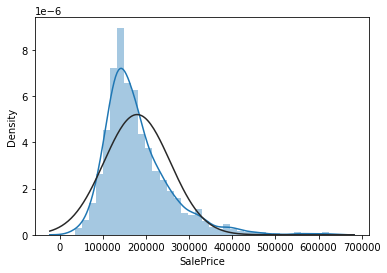

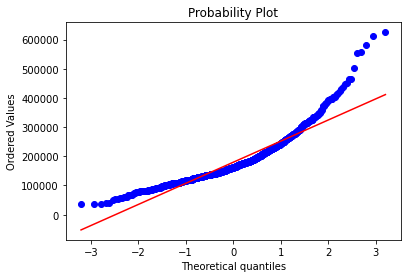

In [ ]:
#analisando y com histograma e plot de distribuicao de probabilidade
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

Como é possível ver, SalePrice tem *'peakedness'*, *'positive skewness'* e não segue a linha de distribuição normal da diagonal. Como temos um caso de *'positive skewness'*, aplicar log deve resolver.

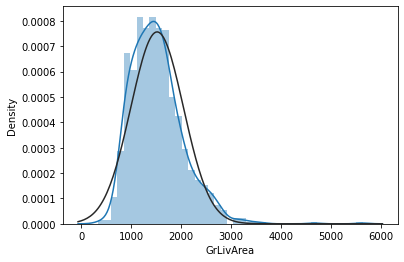

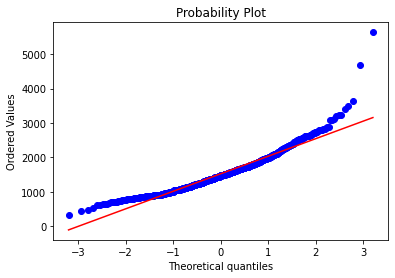

In [ ]:
# histograma e probabilidade normal
sns.distplot(train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['GrLivArea'], plot=plt)

GrLivArea também apresenta skewness, então também vou logar. Além disso, vou retirar possíveis outliers que tiverem valor superior a 4500.


In [15]:
train = train[train.GrLivArea < 4500]
train["GrLivArea"] = np.log1p(train["GrLivArea"])
train.reset_index(drop=True, inplace=True)
train["SalePrice"] = np.log1p(train["SalePrice"])
y = train['SalePrice'].reset_index(drop=True) #já definindo meu y

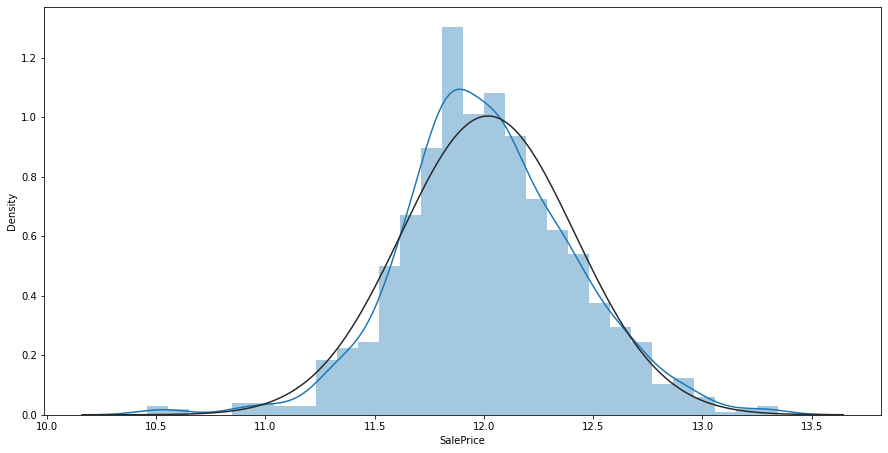

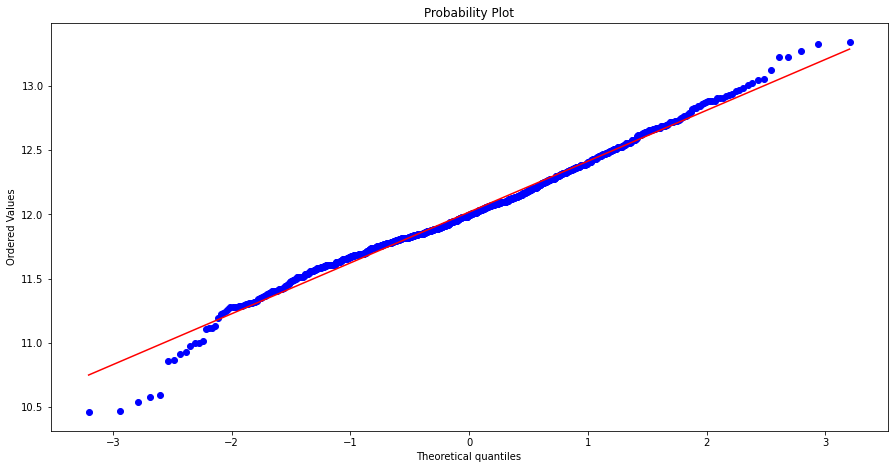

In [16]:
# vendo se funcionou
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

Funcionou!

### Organizando os dados


In [17]:
#tirando SalePrice do subconjunto de treino
train_features = train.drop(['SalePrice'], axis=1)
test_features = test
features = pd.concat([train_features, test_features]).reset_index(drop=True)

#com features, dá para tratar missing values de uma vez

In [18]:
#essas variáveis são categóricas, então preciso fazer com que o python 
#as leia como str e não como número
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

In [19]:
#dando uma olhada na tabela
pd.set_option('display.max_columns', None)
features.sort_index(axis=1, inplace=True)
features.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SalePrice,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,923,0,0,NaN,2,TwnhsE,TA,No,543,119,BLQ,BLQ,0,0,Gd,261,Y,Norm,Norm,SBrkr,0,TA,TA,Plywood,Plywood,NaN,TA,1,CBlock,2,Typ,264,1,TA,RFn,TA,Attchd,1980.0,6.828712,0,GasA,TA,1Story,1,TA,Lvl,Gtl,8012,Inside,50.0,Reg,0,120,RL,0.0,None,NaN,0,5,SawyerW,0,5,6,Y,0,NaN,CompShg,Gable,Normal,NaN,WD,0,Pave,5,923,AllPub,80,1980,1980,2010
1,1578,0,0,NaN,3,1Fam,TA,No,0,0,Unf,Unf,0,0,Gd,1573,Y,Norm,Norm,SBrkr,0,TA,Gd,CemntBd,CmentBd,NaN,Gd,1,PConc,2,Typ,840,3,TA,Fin,TA,Attchd,2008.0,7.364547,0,GasA,Ex,1Story,1,Ex,Lvl,Gtl,9262,Inside,78.0,Reg,0,20,RL,194.0,Stone,NaN,0,5,Somerst,36,5,8,Y,0,NaN,CompShg,Gable,Partial,NaN,New,0,Pave,7,1573,AllPub,0,2008,2009,2009
2,879,984,0,NaN,4,1Fam,TA,Av,0,0,Unf,Unf,0,0,Gd,879,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,Gd,1,PConc,2,Typ,660,3,TA,Fin,TA,BuiltIn,2006.0,7.530480,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,14054,Inside,58.0,IR1,0,60,RL,0.0,None,NaN,0,11,Gilbert,17,5,7,Y,0,NaN,CompShg,Gable,Partial,NaN,New,0,Pave,9,879,AllPub,100,2006,2006,2006
3,2898,0,0,NaN,2,1Fam,TA,Av,1165,400,ALQ,LwQ,1,0,Gd,0,Y,Norm,Norm,SBrkr,174,TA,Gd,Stone,HdBoard,NaN,Gd,1,CBlock,2,Typ,665,2,TA,Fin,TA,Attchd,1976.0,7.972121,0,GasA,TA,1Story,1,Gd,Lvl,Gtl,15498,Corner,NaN,IR1,0,20,RL,0.0,None,NaN,0,5,Timber,72,6,8,Y,0,NaN,WdShake,Hip,Abnorml,NaN,COD,0,Pave,10,1565,AllPub,0,1976,1976,2008
4,774,1194,0,NaN,4,1Fam,TA,No,0,0,Unf,Unf,0,0,Ex,774,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,Gd,1,PConc,2,Typ,680,3,TA,Fin,TA,BuiltIn,2009.0,7.585281,1,GasA,Ex,2Story,1,Ex,Lvl,Gtl,12003,Corner,92.0,Reg,0,60,RL,84.0,BrkFace,NaN,0,5,Timber,75,5,8,Y,0,NaN,CompShg,Gable,Partial,NaN,New,0,Pave,8,774,AllPub,0,2009,2010,2010


In [20]:
features["Functional"].value_counts()

Typ     1358
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

In [21]:
features["Electrical"].value_counts()

SBrkr    1332
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [22]:
features["KitchenQual"].value_counts()

TA    735
Gd    586
Ex     98
Fa     39
Name: KitchenQual, dtype: int64

In [23]:
#preenchendo com os mais frequentes
#analise exploratória das variaveis feita no excel, aqui só arrumo os dados
features['Functional'] = features['Functional'].fillna('Typ') 
features['Electrical'] = features['Electrical'].fillna("SBrkr") 
features['KitchenQual'] = features['KitchenQual'].fillna("TA") 
features["PoolQC"] = features["PoolQC"].fillna("None")

features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0]) 
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

Além disso, se falta dado para as informações de garagem, provavelmente a casa não possui uma.

In [24]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')

    
# o mesmo com o porão

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

In [25]:
#penso em covariancia aqui, entao MSZoning será semelhante a MSSubClass
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [26]:
#None para os demais objetos
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)
features.update(features[objects].fillna('None'))

In [27]:
#LotFrontage tem muita informação para ser deletada, entao preencho com o valor médio
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

#0 para os demais numeros
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))

In [28]:
#corrigindo skewness das demais
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

### Feature Engineering

In [29]:
# retirando
features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

#inserindo
features['YrBltAndRemod'] = features['YearBuilt'] + features['YearRemodAdd']
features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_SF'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

In [30]:
#aplicando logica
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 
                                                 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 
                                                     else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 
                                                     else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 
                                                    else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 
                                                        else 0)

In [31]:
#one-hot enconding para as categoricas serem computaveis
final_features = pd.get_dummies(features).reset_index(drop=True)
final_features.shape

(1458, 333)

In [32]:
#spliting again
X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(y):, :]


### Outliers

In [34]:
#base já anunciou alguns outliers
outliers = [30, 88, 462, 631]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

In [35]:
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.90:
        overfit.append(i)

overfit = list(overfit)
X = X.drop(overfit, axis=1)
X_sub = X_sub.drop(overfit, axis=1)
overfit

['SalePrice',
 'Condition1_RRNe',
 'Condition2_Artery',
 'Condition2_PosA',
 'Condition2_PosN',
 'Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn',
 'Electrical_Mix',
 'ExterCond_Po',
 'Exterior1st_AsphShn',
 'Exterior1st_BrkComm',
 'Exterior1st_CBlock',
 'Exterior1st_ImStucc',
 'Exterior1st_Stone',
 'Exterior2nd_CBlock',
 'Exterior2nd_Other',
 'Functional_Sev',
 'GarageCond_Ex',
 'GarageQual_Ex',
 'Heating_Floor',
 'HeatingQC_Po',
 'MiscFeature_Gar2',
 'MiscFeature_Othr',
 'MiscFeature_TenC',
 'Neighborhood_Blueste',
 'RoofMatl_Membran',
 'RoofMatl_Metal',
 'RoofMatl_Roll',
 'RoofStyle_Shed',
 'SaleType_Con']

Então, não preciso dropar

###Modeling

In [36]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

#funcoes de erro

def mape(y,y_pred):
    mape = (mean_absolute_percentage_error(y, y_pred))
    return mape

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [37]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [38]:
linear = LinearRegression().fit(X,y)
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                       

In [39]:
linear = LinearRegression().fit(X,y)
linear.score(X,y)

0.9598662833440512

In [40]:
print("Com rmse:")

score = cv_rmse(ridge , X)
print("Ridge: {:.4f} ({:.4f})\n".format(score.mean(), score.std()) )

score = cv_rmse(lasso , X)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()) )

score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()) )

Com rmse:
Ridge: 0.1111 (0.0196)

LASSO: 0.1085 (0.0174)

elastic net: 0.1086 (0.0173)



Será que dá para melhorar?
O Prof. Curado falou certa vez de uma técnica de blending para os modelos. Vou testar :)

### Blending

In [41]:
stack_gen = StackingCVRegressor(regressors=(linear, ridge, lasso, elasticnet),
                                meta_regressor = lasso,
                                use_features_in_secondary=True)

In [42]:
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

linear_model_full_data = linear.fit(X, y)

elastic_model_full_data = elasticnet.fit(X, y)

lasso_model_full_data = lasso.fit(X, y)

ridge_model_full_data = ridge.fit(X, y)

Blending os modelos

In [44]:
##tentei descobrir os parâmetros para o blending, mas não consegui :()
#def get_models():
# models = list()
#models.append(('stack', stack_gen_model))
#models.append(('linear', LinearRegression()))
#models.append(('elastic', elastic_model_full_data))
#models.append(('lasso', lasso_model_full_data))
#models.append(('ridge', ridge_model_full_data))
#return models

In [50]:
#se eu incluir linear, fica ruim
def blend_models_predict(X):
    return ((0.1 * linear_model_full_data.predict(X)) +\
            (0.20 * elastic_model_full_data.predict(X)) + \
            (0.15 * lasso_model_full_data.predict(X)) + \
            (0.25 * ridge_model_full_data.predict(X)) + \
            (0.4 * stack_gen_model.predict(np.array(X))))

In [51]:
print('MAPE score:')
print(mape(y, blend_models_predict(X)))
print('')
print('RMSLE score:')
print(rmsle(y, blend_models_predict(X)))

MAPE score:
0.10008351118462085

RMSLE score:
1.2057316064576205


In [52]:
#tirei e ficou melhor
def blend_models_predict(X):
    return ((0.20 * elastic_model_full_data.predict(X)) + \
            (0.15 * lasso_model_full_data.predict(X)) + \
            (0.25 * ridge_model_full_data.predict(X)) + \
            (0.4 * stack_gen_model.predict(np.array(X))))

In [53]:
print('MAPE score:')
print(mape(y, blend_models_predict(X)))
print('')
print('RMSLE score:')
print(rmsle(y, blend_models_predict(X)))

MAPE score:
0.005318355762689162

RMSLE score:
0.09163459795816199


# Exercício 02

In [56]:
url = 'https://raw.githubusercontent.com/gbam-ds/Lista/main/student-mat.csv'
df_mat = pd.read_csv(url, index_col=0)

In [55]:
url = 'https://raw.githubusercontent.com/gbam-ds/Lista/main/student-por.csv'
df_port = pd.read_csv(url, index_col=0)

##Matemática

### Análise exploratória - matemática

In [57]:
#prof pediu para dropar pq é mt correlacionada
df_mat.drop(["G1", "G2"], axis=1, inplace=True)
df_port.drop(["G1", "G2"], axis=1, inplace=True)

In [58]:
#missing data
total = df_mat.isnull().sum().sort_values(ascending=False)
percent = (df_mat.isnull().sum()/df_mat.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
sex,0,0.0
age,0,0.0
absences,0,0.0
health,0,0.0
Walc,0,0.0
Dalc,0,0.0
goout,0,0.0
freetime,0,0.0
famrel,0,0.0
romantic,0,0.0


In [59]:
#missing data
total = df_port.isnull().sum().sort_values(ascending=False)
percent = (df_port.isnull().sum()/df_port.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
sex,0,0.0
age,0,0.0
absences,0,0.0
health,0,0.0
Walc,0,0.0
Dalc,0,0.0
goout,0,0.0
freetime,0,0.0
famrel,0,0.0
romantic,0,0.0


Não tem missing values

Avaliando desempenho em matemática

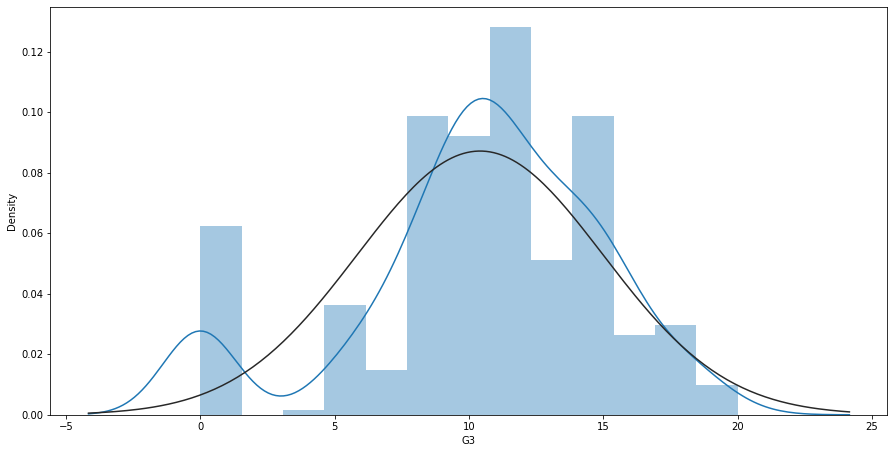

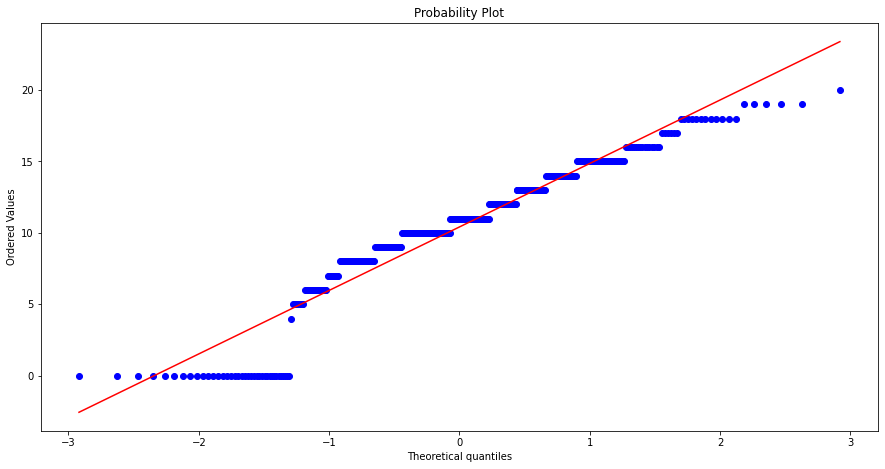

In [60]:
#avaliando G3
#analisando y com histograma e plot de distribuicao de probabilidade
sns.distplot(df_mat['G3'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_mat['G3'], plot=plt)

In [61]:
#normalizando com zscore
from scipy.stats import zscore
df_mat['G3'] = zscore(df_mat['G3'])

In [63]:
#limite como na aula
n_mat = 3
upper_limit = df_mat['G3'].mean() + n_mat*df_mat['G3'].std()
lower_limit = df_mat['G3'].mean() - n_mat*df_mat['G3'].std()

#trimmed
mat_trimmed = + df_mat[(df_mat['G3'] < upper_limit) &
                       (df_mat['G3'] > lower_limit)]

#censored
mat_censored = pd.DataFrame()
mat_censored['G3'] = np.where(df_mat['G3'] > upper_limit, upper_limit,
np.where(df_mat['G3'] < lower_limit, lower_limit, df_mat['G3']))

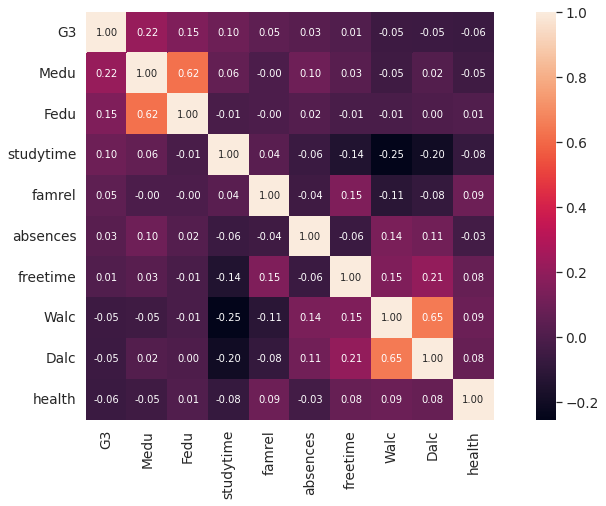

In [67]:
#correlação
corrmat = df_mat.corr()

k = 10
cols = corrmat.nlargest(k, 'G3')['G3'].index
cm = np.corrcoef(df_mat[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3,alc
school,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,-0.967383,2
GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,-0.967383,2
GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,-0.09097,5
GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,1.004547,2
GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,-0.09097,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MS,M,20,U,LE3,A,2,2,services,services,course,other,1,2,2,no,yes,yes,no,yes,yes,no,no,5,5,4,4,5,4,11,-0.310073,9
MS,M,17,U,LE3,T,3,1,services,services,course,mother,2,1,0,no,no,no,no,no,yes,yes,no,2,4,5,3,4,2,3,1.223651,7
MS,M,21,R,GT3,T,1,1,other,other,course,other,1,1,3,no,no,no,no,no,yes,no,no,5,5,3,3,3,3,3,-0.74828,6


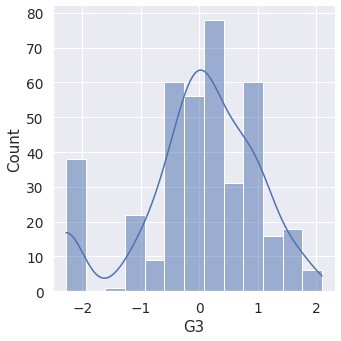

In [76]:
#desnormalizar os dados
mat_n = mat_trimmed
mat_n['G3'] = mat_n['G3']* df_mat['G3'].std() + df_mat['G3'].mean()
sns.displot(mat_n['G3'], kde = True)
mat_n

###Determinantes para matemática

In [70]:
#analisando com simples mqo
mat_n['alc'] = mat_n['Dalc'] + mat_n['Walc'] #alc representa o consumo de alcool, regardless

X = mat_n[["Medu", "Fedu","famrel", "studytime", "absences", "alc", "Dalc", "Walc"]]
y = mat_n["G3"]
X = sm.add_constant(X)
model = sm.OLS(y.astype(float), X.astype(float)).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     3.503
Date:                Sun, 15 May 2022   Prob (F-statistic):            0.00117
Time:                        23:06:30   Log-Likelihood:                -548.85
No. Observations:                 395   AIC:                             1114.
Df Residuals:                     387   BIC:                             1146.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9151      0.321     -2.852      0.005      -1.546      -0.284
Medu           0.1736      0.059      2.963      0.003       0.058       0.289
Fedu           0.0320      0.058      0.548      0.584      -0.083       0.147
famrel         0.0532      0.056      0.959      0.338      -0.056       0.162
studytime      0.0940      0.061      1.536      0.125      -0.026       0.214
absences       0.0032      0.006      0.507      0.613      -0.009       0.016
alc           -0.0157      0.019     -0.819      0.413      -0.053       0.022
Dalc          -0.0403      0.061     -0.660      0.510      -0.160       0.080
Walc           0.0246      0.053      0.463      0.644      -0.080       0.129
==============================================================================
Omnibus:                       33.950   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.213
Skew:                          -0.760   Prob(JB):                     1.85e-09
Kurtosis:                       3.361   Cond. No.                     1.02e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.78e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Achados:


1. Coeficientes baixos.  
2. Nível de educação dos pais tem efeito positivo no rendimento do aluno, em termos de nota. Vale ressaltar que a a eduação da mãe tem impacto maior. Minha hipótese é que mães passam mais tempo com os filhos e os ajudam a estudar.
3.   O segundo conjunto que afeta as notas positivamente é a relação familiar. Isto é, em termos populares, se o aluno estiver bem em casa, ele tende a estar bem na escola.



###Impacto do álcool em matemática

Impactos do consumo de álcool nas notas de matemática.

Achados notáveis:
1. Beber, em geral (alc), tende a diminuir a nota levemente
2. Beber de fim de semana (walc) tende a aumentar um pouco a nota
3. Beber durante a semana (dalc) tende a diminuir um pouco a nota

##Português

### Análise exploratória - português

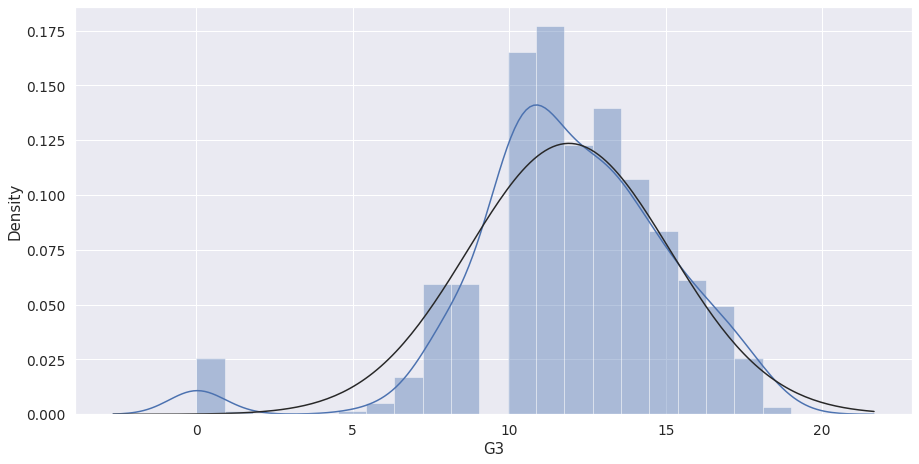

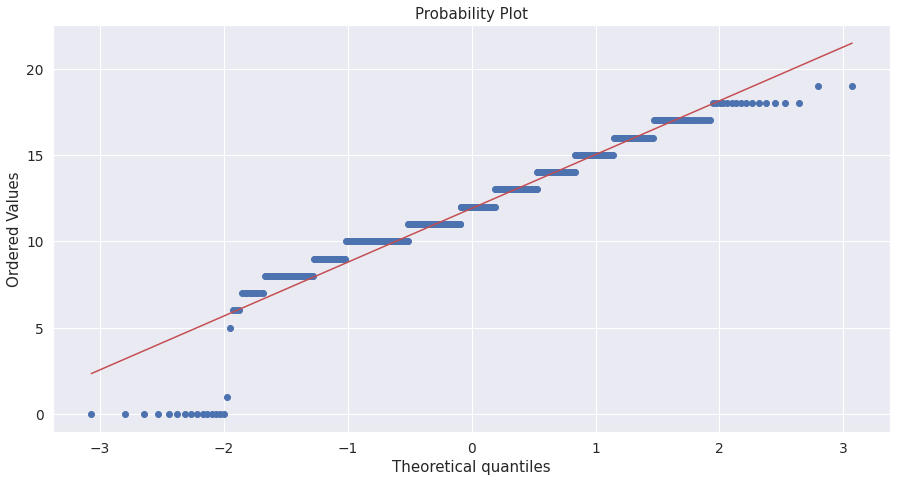

In [71]:
#avaliando G3
#analisando y com histograma e plot de distribuicao de probabilidade
sns.distplot(df_port['G3'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_port['G3'], plot=plt)

In [72]:
#normalizando com zscore
df_port['G3'] = zscore(df_port['G3'])

In [73]:
#limite como na aula
n_port = 3
upper_limit = df_port['G3'].mean() + n_port*df_port['G3'].std()
lower_limit = df_port['G3'].mean() - n_port*df_port['G3'].std()

#trimmed
port_trimmed = + df_port[
(df_port['G3'] < upper_limit) &
(df_port['G3'] > lower_limit)
]

#censored
port_censored = pd.DataFrame()
port_censored['G3'] = np.where(df_port['G3'] > upper_limit, upper_limit,
np.where(df_port['G3'] < lower_limit, lower_limit, df_port['G3']))

,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3
school,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,-0.280874
GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,-0.280874
GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,0.029138
GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,0.649163
GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,0.339151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MS,F,19,R,GT3,T,2,3,services,other,course,mother,1,3,1,no,no,no,yes,no,yes,yes,no,5,4,2,1,2,5,4,-0.590886
MS,F,18,U,LE3,T,3,1,teacher,services,course,mother,1,2,0,no,yes,no,no,yes,yes,yes,no,4,3,4,1,1,1,4,1.269188
MS,F,18,U,GT3,T,1,1,other,other,course,mother,2,2,0,no,no,no,yes,yes,yes,no,no,1,1,1,1,1,5,6,-0.900899


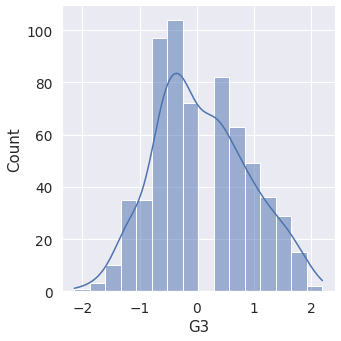

In [74]:
#analisando
port_n = port_trimmed
port_n['G3'] = port_n['G3']* df_port['G3'].std() + df_port['G3'].mean()
sns.displot(port_n['G3'], kde = True)
port_n

###Determinantes para português

In [75]:
port_n['alc'] = port_n['Dalc'] + port_n['Walc']

X = port_n[["Medu", "Fedu","famrel", "studytime", "absences", "alc", "Dalc", "Walc"]]
y = port_n["G3"]
X = sm.add_constant(X)
model = sm.OLS(y.astype(float), X.astype(float)).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     19.81
Date:                Sun, 15 May 2022   Prob (F-statistic):           4.88e-24
Time:                        23:09:50   Log-Likelihood:                -711.47
No. Observations:                 633   AIC:                             1439.
Df Residuals:                     625   BIC:                             1475.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6023      0.182     -3.312      0.001      -0.959      -0.245
Medu           0.1593      0.035      4.599      0.000       0.091       0.227
Fedu           0.0438      0.036      1.231      0.219      -0.026       0.114
famrel         0.0376      0.032      1.184      0.237      -0.025       0.100
studytime      0.1819      0.037      4.919      0.000       0.109       0.255
absences      -0.0259      0.007     -3.928      0.000      -0.039      -0.013
alc           -0.0425      0.011     -3.755      0.000      -0.065      -0.020
Dalc          -0.0565      0.035     -1.612      0.107      -0.125       0.012
Walc           0.0140      0.031      0.457      0.648      -0.046       0.074
==============================================================================
Omnibus:                        6.115   Durbin-Watson:                   1.574
Prob(Omnibus):                  0.047   Jarque-Bera (JB):                5.978
Skew:                           0.205   Prob(JB):                       0.0503
Kurtosis:                       2.758   Cond. No.                     5.64e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.52e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Achados semelhantes aos determinantes para matemática:

1. Nível de educação dos pais tem efeito positivo no rendimento do aluno, em termos de nota. Vale ressaltar que a a eduação da mãe tem impacto maior. Minha hipótese é que mães passam mais tempo com os filhos e os ajudam a estudar.
2. O segundo conjunto que afeta as notas positivamente é a relação familiar. Isto é, em termos populares, se o aluno estiver bem em casa, ele tende a estar bem na escola.

###Impacto do álcool em português

Impactos do consumo de álcool semelhantes aos impactos na matemática.

Achados notáveis:
1. Em geral (alc), tende a beber diminui a nota levemente
2. Beber de fim de semana (walc) tende a aumentar um pouco a nota
3. Beber durante a semana (dalc) tende a diminuir um pouco a nota